# บทที่ 4n - NLP คืออะไร? บทเรียนจากอดีตสู่ปัจจุบัน

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/ai-builders/curriculum/blob/main/notebooks/04n_NLP_Thai_Text_Classification.ipynb)


In [ ]:
!wget https://github.com/PyThaiNLP/wisesight-sentiment/archive/master.zip; unzip master.zip
!mv wisesight-sentiment-master/kaggle-competition/* .
!pip -q install tensorflow_text
!pip -q install pythainlp==3.0.0
!pip -q install emoji
!pip -q install python-crfsuite
!ls

--2022-04-30 07:33:09--  https://github.com/PyThaiNLP/wisesight-sentiment/archive/master.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/PyThaiNLP/wisesight-sentiment/zip/refs/heads/master [following]
--2022-04-30 07:33:09--  https://codeload.github.com/PyThaiNLP/wisesight-sentiment/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip.2’

master.zip.2            [     <=>            ]   6.07M  3.85MB/s    in 1.6s    

2022-04-30 07:33:11 (3.85 MB/s) - ‘master.zip.2’ saved [6365495]

Archive:  master.zip
66eb261de09f88e842ae57bee0b8471ae2c30c1f
replace wisesight-sentiment-master/.gitignore? [y]e

# โค้ดต้นฉบับจาก: Wisesight Sentiment Competition https://github.com/PyThaiNLP/wisesight-sentiment/blob/master/kaggle-competition/competition.ipynb

In [ ]:
import pandas as pd
import numpy as np
from pythainlp import word_tokenize
from tqdm import tqdm_notebook
import re
import emoji

#viz
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def replace_url(text):
    URL_PATTERN = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
    return re.sub(URL_PATTERN, 'xxurl', text)

def replace_rep(text):
    def _replace_rep(m):
        c,cc = m.groups()
        return f'{c}xxrep'
    re_rep = re.compile(r'(\S)(\1{2,})')
    return re_rep.sub(_replace_rep, text)

def ungroup_emoji(toks):
    res = []
    for tok in toks:
        if emoji.emoji_count(tok) == len(tok):
            for char in tok:
                res.append(char)
        else:
            res.append(tok)
    return res

def process_text(text):
    #pre rules
    res = text.lower().strip() # 'AAAA'
    res = replace_url(res)
    res = replace_rep(res) # 'แมวนอนกินปลา' => 'แมว นอน กิน ปลา'
    
    #tokenize
    res = [word for word in word_tokenize(res) if word and not re.search(pattern=r"\s+", string=word)]
    
    #post rules
    res = ungroup_emoji(res)
    
    return res

In [ ]:
with open('train.txt') as f:
    texts = [line.strip() for line in f.readlines()]
f.close()

with open('train_label.txt') as f:
    categories = [line.strip() for line in f.readlines()]
f.close()

all_df = pd.DataFrame({'category':categories, 'texts':texts})
all_df.to_csv('all_df.csv',index=False)
all_df.shape

(24063, 2)

In [ ]:
all_df

,category,texts
0,neu,ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ
1,neu,คะ
2,neg,อิเหี้ยออมทำกูอยากกินเอ็มเค
3,neu,😅😅😅
4,neu,สวัสดีวันพุธ แนน อะไรนะ
...,...,...
24058,neg,แม่งควายล้วนนน
24059,neg,ดอยสุเทพน้องง ไปหมดแล้วววว #pm25
24060,neg,ค่าชุดอาจจะแพงกว่าส่วนลด
24061,neu,รัฐต้องการแค่ภาษีครับ


In [ ]:
with open('test.txt') as f:
    texts = [line.strip() for line in f.readlines()]
f.close()

test_df = pd.DataFrame({'category':'test', 'texts':texts})
test_df.to_csv('test_df.csv',index=False)
test_df.shape

(2674, 2)

In [ ]:
all_df = pd.read_csv('all_df.csv')
test_df = pd.read_csv('test_df.csv')

all_df['processed'] = all_df.texts.map(lambda x: '|'.join(process_text(x)))
all_df['wc'] = all_df.processed.map(lambda x: len(x.split('|')))
all_df['uwc'] = all_df.processed.map(lambda x: len(set(x.split('|'))))

test_df['processed'] = test_df.texts.map(lambda x: '|'.join(process_text(x)))
test_df['wc'] = test_df.processed.map(lambda x: len(x.split('|')))
test_df['uwc'] = test_df.processed.map(lambda x: len(set(x.split('|'))))

In [ ]:
all_df.values.tolist()[0]

['neu',
 'ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ',
 'ประเทศ|เรา|ผลิต|และ|ส่งออก|ยาสูบ|เยอะ|สุด|ใน|โลก|จิง|ป่าว|คับ',
 13,
 13]

In [ ]:
all_df.category.value_counts() / all_df.shape[0]

neu    0.544612
neg    0.255164
pos    0.178698
q      0.021527
Name: category, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_df, test_size=0.15, random_state=1412)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

In [ ]:
train_df.head()

,category,texts,processed,wc,uwc
0,neg,กันแดดคิวเพลสตัวใหม่นี่คุมมันดีจริงอ่ะ นี่หน้า...,กันแดด|คิว|เพลส|ตัวใหม่|นี่|คุม|มัน|ดีจริง|อ่ะ...,29,24
1,neu,พบกับการร่วมตัวของศิลปิน Soul Pop สามยุค สามสไ...,พบ|กับ|การ|ร่วม|ตัว|ของ|ศิลปิน|soul|pop|สาม|ยุ...,107,85
2,neu,👌🏻👌🏻👌🏻😆😆😆,👌🏻👌🏻👌🏻😆|xxrep,2,2
3,neu,จ-ศ แถมถึง 29 ไม่ทันมะว้าาาา,จ|-|ศ|แถม|ถึง|29|ไม่|ทัน|มะ|ว้า|xxrep,11,11
4,neg,ใช้ดีค่ะ บอกต่อ คือเป็นคนเเพ้ง่ายมากกก ใช้กานิ...,ใช้|ดี|ค่ะ|บอกต่อ|คือ|เป็น|คน|เเพ้|ง่าย|มาก|xx...,46,36


In [ ]:
valid_df.head()

,category,texts,processed,wc,uwc
0,neu,เห็นคนลบแอพ viu ก็เห็นใจและเข้าใจเขานะคะ แผลมั...,เห็น|คน|ลบ|แอพ|viu|ก็|เห็นใจ|และ|เข้าใจ|เขา|นะ...,46,41
1,neu,ไปชมไม้คิวของแชมป์ และรองแชมป์ กันจ้า! ..........,ไป|ชม|ไม้คิว|ของ|แชมป์|และ|รอง|แชมป์|กัน|จ้า|!...,41,39
2,neg,กลุ่มรถซีวิคเป็นกลุ่มที่น่ารำคานมากกกกกกกกก อว...,กลุ่ม|รถ|ซีวิค|เป็น|กลุ่ม|ที่|น่า|รำ|คาน|มาก|x...,46,35
3,neu,อยากสวยเหมือนเจ้าของแบรนด์สิคะ เนย โชติกา ใบหน...,อยาก|สวย|เหมือน|เจ้าของ|แบรนด์|สิ|คะ|เนย|โชติ|...,72,56
4,neg,ข้าวโถละร้อย แพง เพราะตักเป็นจานๆละ15 เต็มที่ก...,ข้าว|โถ|ละ|ร้อย|แพง|เพราะ|ตัก|เป็น|จาน|ๆ|ละ|15...,385,215


# Bag-of-Word

In [ ]:
y_train = train_df['category']
y_valid = valid_df['category']

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer(tokenizer=process_text, ngram_range=(1,2), min_df=20, sublinear_tf=True)
tfidf_fit = tfidf.fit(all_df['texts'])
text_train = tfidf_fit.transform(train_df['texts'])
text_valid = tfidf_fit.transform(valid_df['texts'])
text_test = tfidf_fit.transform(test_df['texts'])
text_train.shape, text_valid.shape

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


((20453, 4601), (3610, 4601))

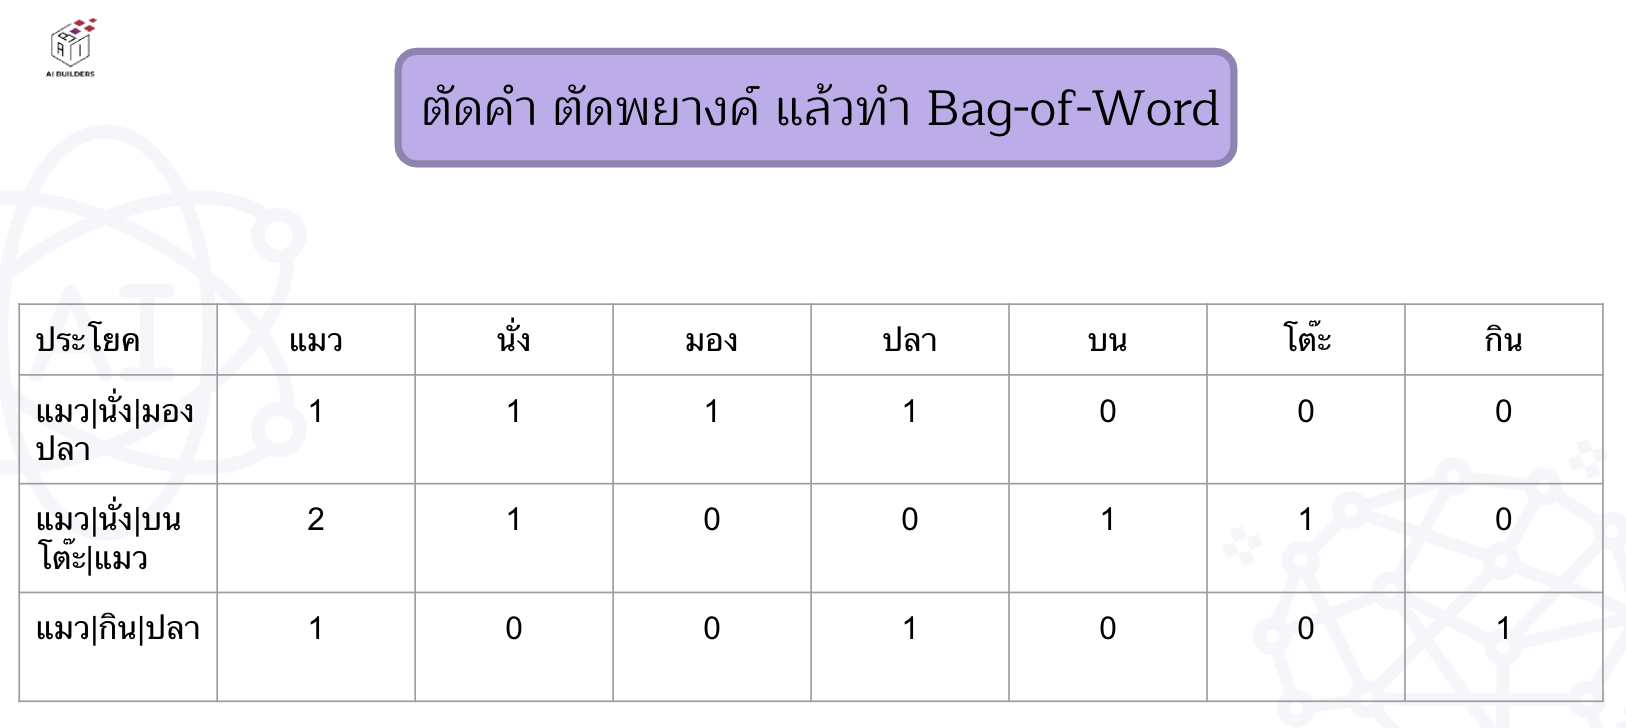

# คำสั่งในการสร้าง BoW 


```
TfidfVectorizer(tokenizer=process_text, ngram_range=(1,2), min_df=20, sublinear_tf=True)
```





```
tokenizer
```



In [ ]:
train_df['texts'].values.tolist()[0]

'กันแดดคิวเพลสตัวใหม่นี่คุมมันดีจริงอ่ะ นี่หน้ามัน ยิ่งทีโซนยิ่งมันเยอะ นีเวียหลอดยาวๆฝาเขียวก็เอาไม่อยู่อ่ะ แล้วช่ว…'

In [ ]:
train_df['processed'].values.tolist()[0].split('|')[:5]

['กันแดด', 'คิว', 'เพลส', 'ตัวใหม่', 'นี่']

In [ ]:
tfidf.get_feature_names_out()

array(['!', '! #', '! .', ..., '🤣 xxrep', '🤤', '🥃'], dtype=object)

In [ ]:
[np.where(tfidf.get_feature_names_out() == x) for x in train_df['processed'].values.tolist()[0].split('|')[:5]]

[(array([747]),),
 (array([1072]),),
 (array([], dtype=int64),),
 (array([1493]),),
 (array([1862]),)]



```
ngram_range
```



In [ ]:
train_df['processed'].values.tolist()[0].split('|')[:5] # ngram = 1
# [กันแดด,คิว,เพลส] # ngram = 3
# [กันแดด+คิว] # ngram =2

['กันแดด', 'คิว', 'เพลส', 'ตัวใหม่', 'นี่']



```
min_df
```





```
sublinear_tf
1 + log(tf)
```



In [ ]:
X_train = text_train.toarray()
X_valid = text_valid.toarray()
X_test = text_test.toarray()
X_train.shape, X_valid.shape

((20453, 4601), (3610, 4601))

In [ ]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
model = LogisticRegression(C=2., penalty='l2', solver='liblinear', dual=False, multi_class='ovr')
model.fit(X_train,y_train)
model.score(X_valid,y_valid)

0.7277008310249308

In [ ]:
from sklearn.metrics import classification_report
y_val_pred = model.predict(X_valid)
print(classification_report(y_valid, y_val_pred))

              precision    recall  f1-score   support

         neg       0.76      0.69      0.72       954
         neu       0.72      0.89      0.80      1959
         pos       0.69      0.37      0.48       617
           q       0.56      0.06      0.11        80

    accuracy                           0.73      3610
   macro avg       0.68      0.50      0.53      3610
weighted avg       0.72      0.73      0.71      3610



# ใช้งานจริง

In [ ]:
sample = ['ร้านอาหารร้านนี้อร่อยดี','อาหารร้านนี้ไม่อร่อยเลย']
sample_feature = tfidf_fit.transform(sample)
model.predict(sample_feature)

array(['pos', 'neg'], dtype=object)

In [ ]:
sample_feature.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# ข้อเสีย

In [ ]:
sample = ['ร้านอาหารร้านนี้อร่อยตรงไหน','อาหารร้านนี้ไม่เคยไม่อร่อยเลย']
sample_feature = tfidf_fit.transform(sample)
model.predict(sample_feature)

array(['pos', 'neg'], dtype=object)

# RNN/LSTM

In [ ]:
import tensorflow as tf

In [ ]:
def process_text_rnn(text):
    #pre rules
    res = text.lower().strip()
    res = replace_url(res)
    res = replace_rep(res)
    
    #tokenize
    res = [word for word in word_tokenize(res) if word and not re.search(pattern=r"\s+", string=word)]
    
    #post rules
    res = ungroup_emoji(res)
    
    return ' '.join(res)

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

text_train = [' '.join(x.split('|')) for x in train_df['processed'].values.tolist()]
text_valid = [' '.join(x.split('|')) for x in valid_df['processed'].values.tolist()]

In [ ]:
text_train[0]

'กันแดด คิว เพลส ตัวใหม่ นี่ คุม มัน ดีจริง อ่ะ นี่ หน้า มัน ยิ่ง ที โซน ยิ่ง มัน เยอะ นีเวีย หลอด ยาว ๆ ฝา เขียว ก็ เอาไม่อยู่ อ่ะ แล้ว ช่ว…'

In [ ]:
word_count = []
for sent in text_train:
  for w in sent.split():
      word_count.append(w)

In [ ]:
word_count[:5]

['กันแดด', 'คิว', 'เพลส', 'ตัวใหม่', 'นี่']

In [ ]:
VOCAB_SIZE = len(set(word_count))
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(text_train)

In [ ]:
VOCAB_SIZE

24518

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'ไม่', 'xxrep', 'ที่', 'ไป', 'ได้', 'มี', 'มา', 'จะ',
       'เลย', 'ก็', 'ๆ', 'ให้', 'แล้ว', 'ครับ', 'ใน', 'และ', 'ของ', 'กิน'],
      dtype='<U39')

In [ ]:
example

'ร้านอาหาร ร้าน นี้ อร่อย'

In [ ]:
example = process_text_rnn('ร้านอาหารร้านนี้อร่อย')
encoded_example = encoder(example).numpy()
encoded_example

array([2009,  108,   24,  188])

In [ ]:
[vocab[x] for x in encoded_example]

['ร้านอาหาร', 'ร้าน', 'นี้', 'อร่อย']

In [ ]:
set(y_train)

{'neg', 'neu', 'pos', 'q'}

In [ ]:
y_train = train_df['category']
y_valid = valid_df['category']
y_class = ['neg', 'neu', 'pos', 'q']

In [ ]:
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical

le = preprocessing.LabelEncoder()
le.fit(y_class)
y_train = le.transform(y_train)
y_val = le.transform(y_valid)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
print(y_train.shape)

(20453, 4)


In [ ]:
train_df['category'].values.tolist()[0]

'neg'

In [ ]:
y_train[0]

array([1., 0., 0., 0.], dtype=float32)

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=512,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

In [ ]:
sample_text = ('ร้านอาหารร้านนี้อร่อยมาก')
predictions = model.predict(np.array([sample_text]))
print(predictions)
le.classes_

[[0.2510082  0.24806166 0.2505245  0.2504056 ]]


array(['neg', 'neu', 'pos', 'q'], dtype='<U3')

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
model.fit(np.array(text_train), y_train, validation_data=(np.array(text_valid), y_val), epochs=3, verbose=2)

Epoch 1/3
640/640 - 71s - loss: 0.9574 - accuracy: 0.6186 - val_loss: 0.7918 - val_accuracy: 0.7042 - 71s/epoch - 112ms/step
Epoch 2/3
640/640 - 54s - loss: 0.6569 - accuracy: 0.7476 - val_loss: 0.7099 - val_accuracy: 0.7163 - 54s/epoch - 84ms/step
Epoch 3/3
640/640 - 53s - loss: 0.5067 - accuracy: 0.8043 - val_loss: 0.7370 - val_accuracy: 0.7180 - 53s/epoch - 82ms/step


In [ ]:
value = model.predict(np.array(text_valid))
y_val_pred = np.argmax(value,axis=1)
y_val_true = np.argmax(y_val,axis=1)
print(classification_report(y_val_true, y_val_pred))

              precision    recall  f1-score   support

           0       0.74      0.69      0.72       954
           1       0.73      0.83      0.78      1959
           2       0.57      0.43      0.49       617
           3       0.50      0.16      0.25        80

    accuracy                           0.71      3610
   macro avg       0.64      0.53      0.56      3610
weighted avg       0.70      0.71      0.70      3610



# Pretrained Representation (CNN)

In [ ]:
import tensorflow_hub as hub
import tensorflow_text
import tensorflow as tf #tensorflow 2.1.0

enc = hub.load('https://tfhub.dev/google/universal-sentence-encoder-multilingual/3')

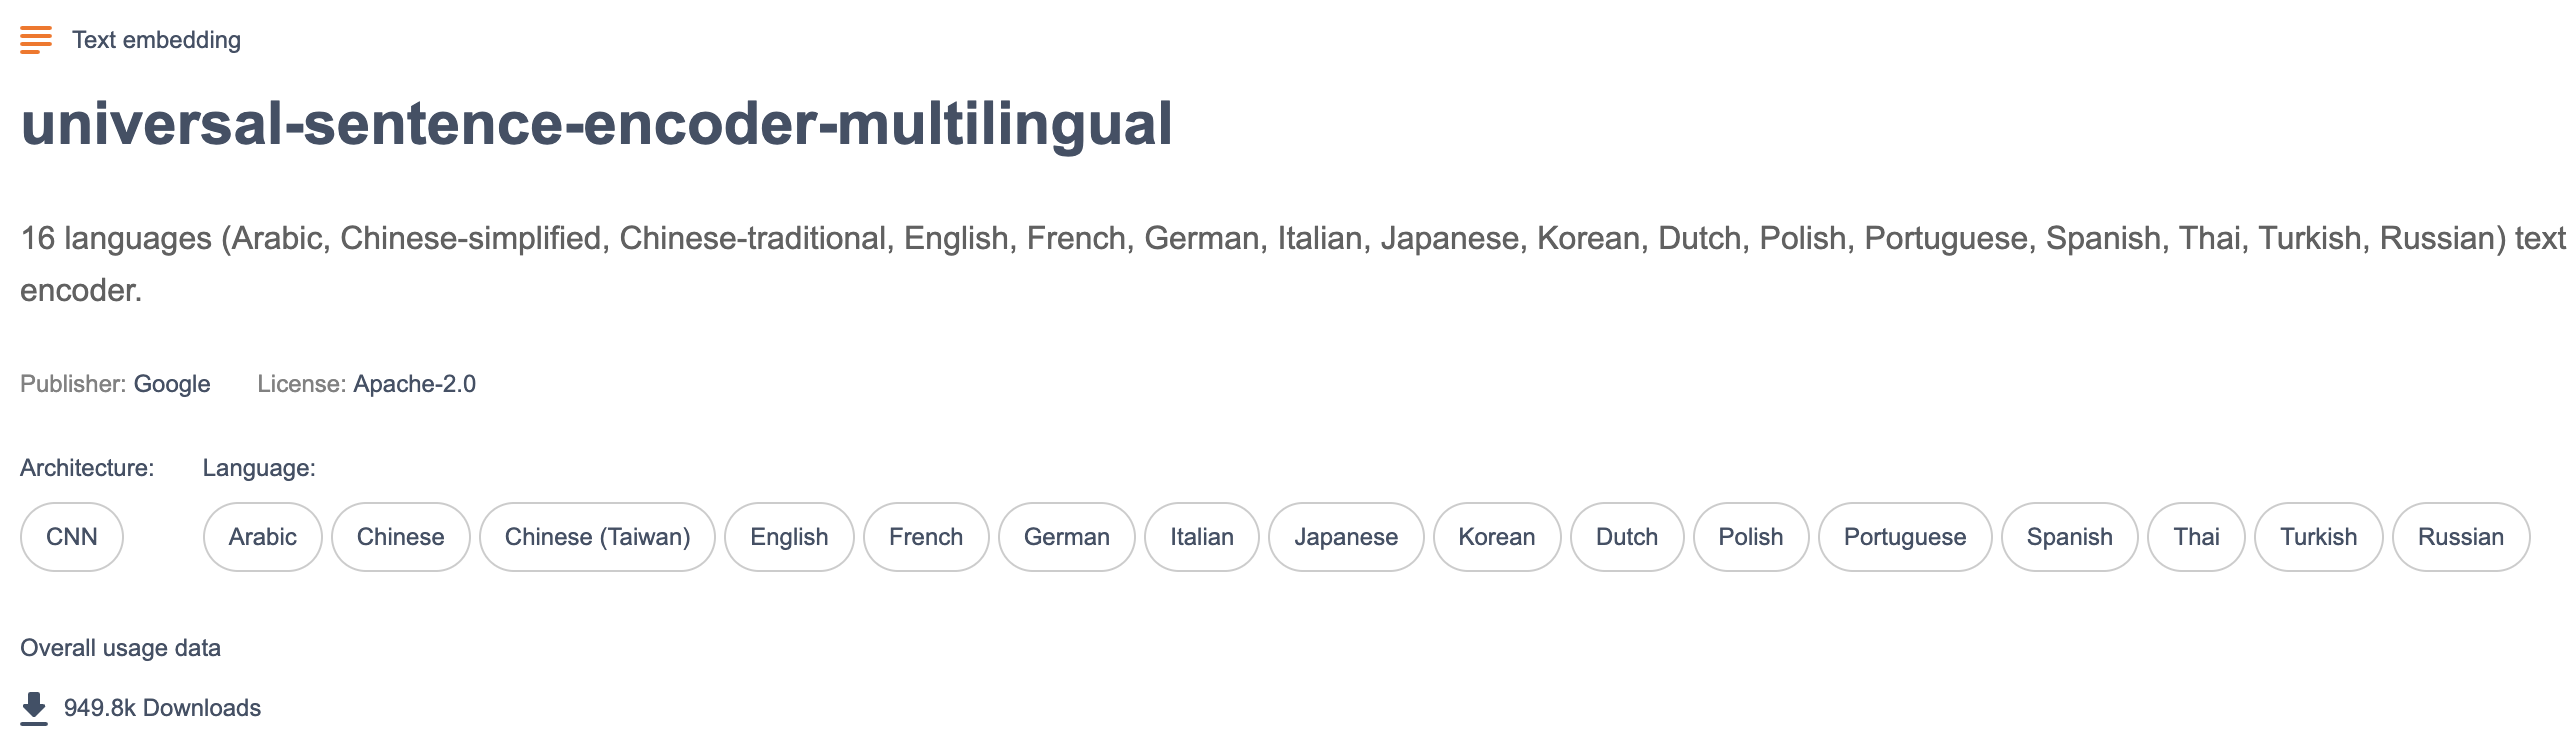



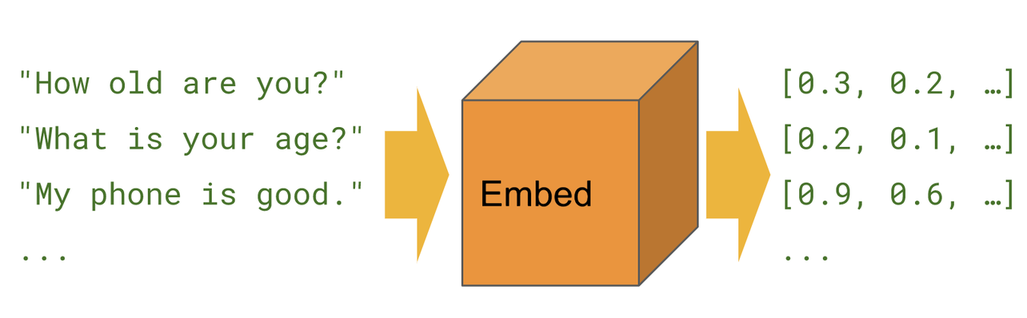

In [ ]:
y_train = train_df['category']
y_valid = valid_df['category']

In [ ]:
X_trains = []
X_vals = []
bs = 10

In [ ]:
for i in tqdm_notebook(range(y_valid.shape[0]//bs+1)):
    X_vals.append(enc(valid_df.texts[(i*bs):((i+1)*bs)]).numpy())

for i in tqdm_notebook(range(y_train.shape[0]//bs+1)):
    X_trains.append(enc(train_df.texts[(i*bs):((i+1)*bs)]).numpy())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/362 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/2046 [00:00<?, ?it/s]

In [ ]:
train_df.texts[0]

'กันแดดคิวเพลสตัวใหม่นี่คุมมันดีจริงอ่ะ นี่หน้ามัน ยิ่งทีโซนยิ่งมันเยอะ นีเวียหลอดยาวๆฝาเขียวก็เอาไม่อยู่อ่ะ แล้วช่ว…'

In [ ]:
enc(train_df.texts[0])

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[ 5.57201467e-02, -6.39803335e-02, -7.77417794e-02,
        -4.98523340e-02, -4.49490920e-03,  3.71704102e-02,
        -8.43040794e-02, -2.59452994e-04, -7.03679547e-02,
         6.70259148e-02, -4.49499264e-02, -3.76391597e-02,
         5.34935817e-02,  3.84743500e-04,  2.12898310e-02,
        -2.36823242e-02, -1.58960931e-02,  4.39886786e-02,
         5.42761497e-02, -4.41913418e-02,  1.38977207e-02,
         4.57215384e-02,  6.74854144e-02,  8.11360311e-03,
         3.61658458e-04,  4.66078073e-02, -2.89318562e-02,
        -2.40138341e-02,  2.09183544e-02, -8.57146736e-03,
         5.95108792e-02,  3.49377282e-02,  4.88796346e-02,
        -4.73291148e-03,  2.26494204e-02, -9.28784385e-02,
        -4.14057150e-02,  2.76025711e-03,  5.81592275e-03,
         2.03649830e-02, -4.60834764e-02, -2.55602337e-02,
         6.79537207e-02,  1.29975926e-03,  6.38208911e-03,
        -4.38436195e-02, -7.71384463e-02,  6.55661225e-02,
      

In [ ]:
X_train[0]

array([ 5.57201430e-02, -6.39803261e-02, -7.77417868e-02, -4.98523228e-02,
       -4.49492736e-03,  3.71703915e-02, -8.43041539e-02, -2.59511173e-04,
       -7.03679696e-02,  6.70258850e-02, -4.49499041e-02, -3.76391746e-02,
        5.34935743e-02,  3.84718471e-04,  2.12898348e-02, -2.36823335e-02,
       -1.58960763e-02,  4.39887010e-02,  5.42761385e-02, -4.41912711e-02,
        1.38977421e-02,  4.57215607e-02,  6.74854368e-02,  8.11364781e-03,
        3.61643470e-04,  4.66078222e-02, -2.89318785e-02, -2.40138303e-02,
        2.09183358e-02, -8.57145339e-03,  5.95108680e-02,  3.49377394e-02,
        4.88796905e-02, -4.73292032e-03,  2.26494391e-02, -9.28784460e-02,
       -4.14057747e-02,  2.76025524e-03,  5.81592321e-03,  2.03649886e-02,
       -4.60833907e-02, -2.55602468e-02,  6.79537207e-02,  1.29974703e-03,
        6.38211146e-03, -4.38436307e-02, -7.71384537e-02,  6.55661374e-02,
        2.78884992e-02,  9.42364614e-03, -5.54346144e-02, -1.54397590e-02,
       -4.52452376e-02,  

In [ ]:
X_val = np.concatenate(X_vals,0)
X_train = np.concatenate(X_trains,0)
X_train.shape, X_val.shape

((20453, 512), (3610, 512))

In [ ]:
from sklearn.svm import LinearSVC

text_clf = LinearSVC(class_weight='balanced')
text_clf.fit(X_train, y_train)

LinearSVC(class_weight='balanced')

In [ ]:
y_val_pred = text_clf.predict(X_val)
print(classification_report(y_valid, y_val_pred))

              precision    recall  f1-score   support

         neg       0.63      0.72      0.67       954
         neu       0.76      0.68      0.71      1959
         pos       0.52      0.46      0.49       617
           q       0.24      0.65      0.35        80

    accuracy                           0.65      3610
   macro avg       0.54      0.63      0.56      3610
weighted avg       0.67      0.65      0.66      3610



# Language Model: BERT

In [ ]:
!pip -q install thai2transformers==0.1.1
!pip install torch==1.7.0

     |████████████████████████████████| 750.6 MB 8.7 kB/s 
  Using cached torch-1.7.0-cp37-cp37m-manylinux1_x86_64.whl (776.7 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.7.0 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.7.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.7.0 which is incompatible.
pytorch-lightning 1.6.2 requires torch>=1.8.*, but you have torch 1.7.0 which is incompatible.


In [ ]:
import pandas as pd
from datasets import load_dataset, load_metric

import torch
from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification,
                          TrainingArguments,
                          Trainer)
from thai2transformers.tokenizers import (
    ThaiRobertaTokenizer,
    ThaiWordsNewmmTokenizer,
    ThaiWordsSyllableTokenizer,
    FakeSefrCutTokenizer
)
from thai2transformers.metrics import classification_metrics

In [ ]:
#parameters
class Args:
    model_name = 'airesearch/wangchanberta-base-att-spm-uncased'
    dataset_name_or_path = 'wisesight_sentiment'
    feature_col = 'texts'
    label_col = 'category'
    output_dir = 'models_wongnai/wangchanberta-base-att-spm-uncased_wongnai'
    batch_size = 16
    warmup_percent = 0.1
    learning_rate = 3e-05
    num_train_epochs = 1
    weight_decay = 0.01
    metric_for_best_model = 'f1_micro'
    seed = 1412

args = Args()

In [ ]:
dataset['train']

Dataset({
    features: ['texts', 'category', 'labels'],
    num_rows: 21628
})

In [ ]:
dataset = load_dataset(args.dataset_name_or_path)
dataset = dataset.map(lambda examples: {'labels': examples[args.label_col]}, batched=True)
num_labels = len(set(dataset['train']['labels']))
dataset

Reusing dataset wisesight_sentiment (/root/.cache/huggingface/datasets/wisesight_sentiment/wisesight_sentiment/1.0.0/fc2b1bdfe79571b2e281e4afdb5aac069cf9270bf0f85694239be672a4191969)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/wisesight_sentiment/wisesight_sentiment/1.0.0/fc2b1bdfe79571b2e281e4afdb5aac069cf9270bf0f85694239be672a4191969/cache-6a9786764cc6e828.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wisesight_sentiment/wisesight_sentiment/1.0.0/fc2b1bdfe79571b2e281e4afdb5aac069cf9270bf0f85694239be672a4191969/cache-4b5070affc275247.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wisesight_sentiment/wisesight_sentiment/1.0.0/fc2b1bdfe79571b2e281e4afdb5aac069cf9270bf0f85694239be672a4191969/cache-0bcf23fed69821f7.arrow


DatasetDict({
    train: Dataset({
        features: ['texts', 'category', 'labels'],
        num_rows: 21628
    })
    validation: Dataset({
        features: ['texts', 'category', 'labels'],
        num_rows: 2404
    })
    test: Dataset({
        features: ['texts', 'category', 'labels'],
        num_rows: 2671
    })
})

In [ ]:
args.model_name

'airesearch/wangchanberta-base-att-spm-uncased'

In [ ]:
#create tokenizer
tokenizer = AutoTokenizer.from_pretrained(args.model_name, model_max_length=416)

#encode dataset
def encode_function(examples):
    return tokenizer(examples[args.feature_col], truncation=True)
encoded_dataset = dataset.map(encode_function, batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/wisesight_sentiment/wisesight_sentiment/1.0.0/fc2b1bdfe79571b2e281e4afdb5aac069cf9270bf0f85694239be672a4191969/cache-771dc1c908ecdcd9.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wisesight_sentiment/wisesight_sentiment/1.0.0/fc2b1bdfe79571b2e281e4afdb5aac069cf9270bf0f85694239be672a4191969/cache-1455cd46a029ff3c.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wisesight_sentiment/wisesight_sentiment/1.0.0/fc2b1bdfe79571b2e281e4afdb5aac069cf9270bf0f85694239be672a4191969/cache-666e556691ef9397.arrow


In [ ]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['texts', 'category', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 21628
    })
    validation: Dataset({
        features: ['texts', 'category', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 2404
    })
    test: Dataset({
        features: ['texts', 'category', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 2671
    })
})

In [ ]:
num_labels

4

In [ ]:
#create model
model = AutoModelForSequenceClassification.from_pretrained(args.model_name, num_labels=num_labels)

Some weights of the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at airesearch/wa

In [ ]:
model

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(25005, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

In [ ]:
train_args = TrainingArguments(
    output_dir = args.output_dir,
    evaluation_strategy = "epoch",
    learning_rate=args.learning_rate,
    per_device_train_batch_size=args.batch_size,
    per_device_eval_batch_size=args.batch_size,
    num_train_epochs=args.num_train_epochs,
    warmup_steps = int(len(encoded_dataset['train']) * args.num_train_epochs // args.batch_size * args.warmup_percent),
    weight_decay=args.weight_decay,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model=args.metric_for_best_model,
    seed = args.seed
)

In [ ]:
classification_metrics

<function thai2transformers.metrics.classification_metrics>

In [ ]:
trainer = Trainer(
    model,
    train_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['validation'],
    tokenizer=tokenizer,
    compute_metrics=classification_metrics
)

In [ ]:
preds  = trainer.predict(encoded_dataset['validation'])
pd.DataFrame.from_dict(preds[2],orient='index').transpose()

,eval_loss,eval_accuracy,eval_f1_micro,eval_precision_micro,eval_recall_micro,eval_f1_macro,eval_precision_macro,eval_recall_macro,eval_nb_samples
0,1.402091,0.265391,0.265391,0.265391,0.265391,0.200525,0.259012,0.254524,2404.0


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Micro,Precision Micro,Recall Micro,F1 Macro,Precision Macro,Recall Macro,Nb Samples
1,0.673224,0.633516,0.734193,0.734193,0.734193,0.734193,0.596665,0.679481,0.563562,2404


TrainOutput(global_step=1352, training_loss=0.7585526867025703)

In [ ]:
preds  = trainer.predict(encoded_dataset['validation'])
pd.DataFrame.from_dict(preds[2],orient='index').transpose()

,eval_loss,eval_accuracy,eval_f1_micro,eval_precision_micro,eval_recall_micro,eval_f1_macro,eval_precision_macro,eval_recall_macro,eval_nb_samples
0,0.633516,0.734193,0.734193,0.734193,0.734193,0.596665,0.679481,0.563562,2404.0
